In [7]:
# --- CÉLULA 1 (v3.1): PREPARAÇÃO DE DADOS LONG/SHORT (COM CORREÇÃO DE DADOS DE PREÇO) ---

import pandas as pd
import numpy as np
import requests
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta

# --------------------------------------------------------------------------
# PASSO 1: CARREGAR FEATURES DE FLUXO E DADOS DE PREÇO (OHLCV)
# --------------------------------------------------------------------------
print("--- 1. Carregando Dados ---")

# 1.1 Carregar as nossas features de fluxo de ordens
features_path = 'user_data/data/binance/trades_agg_90d_BTCUSDT.parquet'
df_features = pd.read_parquet(features_path)
print(f"Features de fluxo de ordens carregadas: {df_features.shape[0]} linhas.")

# 1.2 Descarregar e preparar os dados de preço (OHLCV) - O PASSO QUE FALTAVA
print("Descarregando dados de preço (OHLCV) da API da Binance...")
all_klines = []
end_date = datetime.utcnow()
start_date = end_date - timedelta(days=90)
current_start = start_date
while current_start < end_date:
    url = "https://api.binance.com/api/v3/klines"
    params = {'symbol': 'BTCUSDT', 'interval': '15m', 'startTime': int(current_start.timestamp( ) * 1000), 'endTime': int(end_date.timestamp() * 1000), 'limit': 1000}
    response = requests.get(url, params=params)
    klines = response.json()
    if not klines: break
    all_klines.extend(klines)
    current_start = pd.to_datetime(klines[-1][0], unit='ms') + timedelta(milliseconds=1)

df_ohlcv = pd.DataFrame(all_klines, columns=['date', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
df_ohlcv = df_ohlcv[['date', 'open', 'high', 'low', 'close', 'volume']]
for col in ['open', 'high', 'low', 'close', 'volume']:
    df_ohlcv[col] = pd.to_numeric(df_ohlcv[col])
df_ohlcv['date'] = pd.to_datetime(df_ohlcv['date'], unit='ms')
df_ohlcv.set_index('date', inplace=True)
print(f"Dados de preço (OHLCV) carregados: {df_ohlcv.shape[0]} linhas.")

# 1.3 Juntar os dois DataFrames
df_final = pd.merge(df_features, df_ohlcv, left_index=True, right_index=True, how='inner')
print(f"DataFrame final combinado criado com {df_final.shape[0]} linhas.")


# --------------------------------------------------------------------------
# PASSO 2: CRIAÇÃO DA VARIÁVEL ALVO (MÉTODO DA TRIPLA BARREIRA)
# --------------------------------------------------------------------------
print("\n--- 2. Criando Variável Alvo (Long/Short/Neutro) ---")

take_profit_pct = 0.005
stop_loss_pct = 0.005
time_limit_candles = 5

df_final['target'] = 0

for i in range(len(df_final) - time_limit_candles):
    entry_price = df_final['close'].iloc[i]
    for j in range(1, time_limit_candles + 1):
        future_high = df_final['high'].iloc[i + j]
        future_low = df_final['low'].iloc[i + j]
        
        if future_high >= entry_price * (1 + take_profit_pct):
            df_final.loc[df_final.index[i], 'target'] = 2 # LONG
            break
            
        if future_low <= entry_price * (1 - stop_loss_pct):
            df_final.loc[df_final.index[i], 'target'] = 1 # SHORT
            break
            
df_final = df_final.iloc[:-time_limit_candles]

print("Distribuição da nova variável alvo:")
print(df_final['target'].value_counts(normalize=True))


# --------------------------------------------------------------------------
# PASSO 3: SELEÇÃO DE FEATURES, ESCALONAMENTO E DIVISÃO
# --------------------------------------------------------------------------
print("\n--- 3. Preparando Dados para o Modelo ---")

y = df_final['target']
features_to_drop = ['target', 'open', 'high', 'low', 'close', 'volume']
X = df_final.drop(columns=features_to_drop)
print(f"Dataset preparado com {X.shape[1]} features.")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled_df, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

print("\nDivisão dos dados concluída (sem baralhar):")
print(f"- Amostras de Treino:    {len(X_train)}")
print(f"- Amostras de Validação: {len(X_val)}")
print(f"- Amostras de Teste:     {len(X_test)}")


--- 1. Carregando Dados ---
Features de fluxo de ordens carregadas: 8640 linhas.
Descarregando dados de preço (OHLCV) da API da Binance...


/var/folders/_h/bzklzp017rd0m7tqv52p2lym0000gn/T/ipykernel_14906/3296767340.py:23: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_date = datetime.utcnow()


Dados de preço (OHLCV) carregados: 8624 linhas.
DataFrame final combinado criado com 8520 linhas.

--- 2. Criando Variável Alvo (Long/Short/Neutro) ---
Distribuição da nova variável alvo:
target
0    0.758544
1    0.124956
2    0.116500
Name: proportion, dtype: float64

--- 3. Preparando Dados para o Modelo ---
Dataset preparado com 4 features.

Divisão dos dados concluída (sem baralhar):
- Amostras de Treino:    6812
- Amostras de Validação: 851
- Amostras de Teste:     852


In [8]:
# --- CÉLULA 2 (v3): TREINO DO MODELO PARA CLASSIFICAÇÃO LONG/SHORT/NEUTRO ---

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# --------------------------------------------------------------------------
# PASSO 1: PREPARAR OS DADOS PARA O LSTM
# --------------------------------------------------------------------------
print("--- 1. Preparando dados para o formato do LSTM ---")

# Função para criar sequências (a mesma de antes)
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 10  # Usar 10 velas anteriores para prever a próxima

X_train_seq, y_train_seq = create_sequences(X_train, y_train, TIME_STEPS)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, TIME_STEPS)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, TIME_STEPS)

# --- MUDANÇA CRÍTICA: One-Hot Encoding da variável alvo ---
# Transforma o alvo (0, 1, 2) em vetores, ex: 2 -> [0, 0, 1]
y_train_cat = to_categorical(y_train_seq, num_classes=3)
y_val_cat = to_categorical(y_val_seq, num_classes=3)
y_test_cat = to_categorical(y_test_seq, num_classes=3)

print(f"Formato dos dados de treino: {X_train_seq.shape}")
print(f"Formato do alvo de treino (após to_categorical): {y_train_cat.shape}")


# --------------------------------------------------------------------------
# PASSO 2: CONSTRUIR E TREINAR O MODELO
# --------------------------------------------------------------------------
print("\n--- 2. Construindo e Treinando o Modelo Long/Short ---")

# A arquitetura é a mesma, mas a camada final muda
model_v3 = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    # --- MUDANÇA CRÍTICA: 3 neurônios e ativação 'softmax' ---
    Dense(3, activation='softmax') 
])

# Compila o modelo com 'categorical_crossentropy' para múltiplas classes
model_v3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_v3.summary()

# Callbacks para parar o treino e salvar o melhor modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('oraculo_v3_long_short_model.h5', monitor='val_loss', save_best_only=True)

# Treina o modelo
history_v3 = model_v3.fit(
    X_train_seq, y_train_cat,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_seq, y_val_cat),
    callbacks=[early_stopping, model_checkpoint]
)

print("\n--- Treino Concluído! ---")
print("O melhor modelo foi salvo em 'oraculo_v3_long_short_model.h5'")


--- 1. Preparando dados para o formato do LSTM ---
Formato dos dados de treino: (6802, 10, 4)
Formato do alvo de treino (após to_categorical): (6802, 3)

--- 2. Construindo e Treinando o Modelo Long/Short ---


/Users/marianobernini/miniconda/envs/botenv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            78 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,553 (127.16 KB)

 Trainable params: 32,553 (127.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7044 - loss: 0.7839

213/213 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7313 - loss: 0.7266 - val_accuracy: 0.7919 - val_loss: 0.6509
Epoch 2/100
211/213 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7479 - loss: 0.6842

213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7402 - loss: 0.6920 - val_accuracy: 0.7919 - val_loss: 0.6477
Epoch 3/100
212/213 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7428 - loss: 0.6774

213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7424 - loss: 0.6880 - val_accuracy: 0.7943 - val_loss: 0.6342
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7440 - loss: 0.6832 - val_accuracy: 0.7943 - val_loss: 0.6580
Epoch 5/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7458 - loss: 0.6795 - val_accuracy: 0.7919 - val_loss: 0.6526
Epoch 6/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7460 - loss: 0.6821 - val_accuracy: 0.7895 - val_loss: 0.6353
Epoch 7/100
211/213 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7465 - loss: 0.6841

213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7468 - loss: 0.6770 - val_accuracy: 0.7919 - val_loss: 0.6294
Epoch 8/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7455 - loss: 0.6761 - val_accuracy: 0.7907 - val_loss: 0.6311
Epoch 9/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7483 - loss: 0.6738 - val_accuracy: 0.7919 - val_loss: 0.6369
Epoch 10/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7432 - loss: 0.6705

213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7468 - loss: 0.6690 - val_accuracy: 0.7990 - val_loss: 0.6223
Epoch 11/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7490 - loss: 0.6706 - val_accuracy: 0.7931 - val_loss: 0.6283
Epoch 12/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7518 - loss: 0.6663 - val_accuracy: 0.7907 - val_loss: 0.6347
Epoch 13/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7498 - loss: 0.6671 - val_accuracy: 0.7895 - val_loss: 0.6393
Epoch 14/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7495 - loss: 0.6699 - val_accuracy: 0.7955 - val_loss: 0.6315
Epoch 15/100
211/213 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7490 - loss: 0.6649

213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7489 - loss: 0.6670 - val_accuracy: 0.7919 - val_loss: 0.6170
Epoch 16/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7510 - loss: 0.6622 - val_accuracy: 0.7990 - val_loss: 0.6245
Epoch 17/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7499 - loss: 0.6609 - val_accuracy: 0.7955 - val_loss: 0.6336
Epoch 18/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7521 - loss: 0.6588 - val_accuracy: 0.7919 - val_loss: 0.6510
Epoch 19/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7520 - loss: 0.6548 - val_accuracy: 0.7967 - val_loss: 0.6403
Epoch 20/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.7515 - loss: 0.6532 - val_accuracy: 0.7895 - val_loss: 0.6587
Epoch 21/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7554 - loss: 0.6545 - val_accuracy: 0.7872 - val_loss: 0.6563
Epoch 22/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7507 - loss: 0.6516 - val_a

--- 1. Carregando o melhor modelo treinado ---

--- 2. Fazendo previsões no conjunto de teste ---
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

--- 3. Relatório de Classificação ---
              precision    recall  f1-score   support

  Neutro (0)       0.86      0.99      0.92       718
   Short (1)       0.12      0.04      0.06        51
    Long (2)       0.00      0.00      0.00        73

    accuracy                           0.84       842
   macro avg       0.33      0.34      0.33       842
weighted avg       0.74      0.84      0.79       842


--- 4. Matriz de Confusão ---


/Users/marianobernini/miniconda/envs/botenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/marianobernini/miniconda/envs/botenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/marianobernini/miniconda/envs/botenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

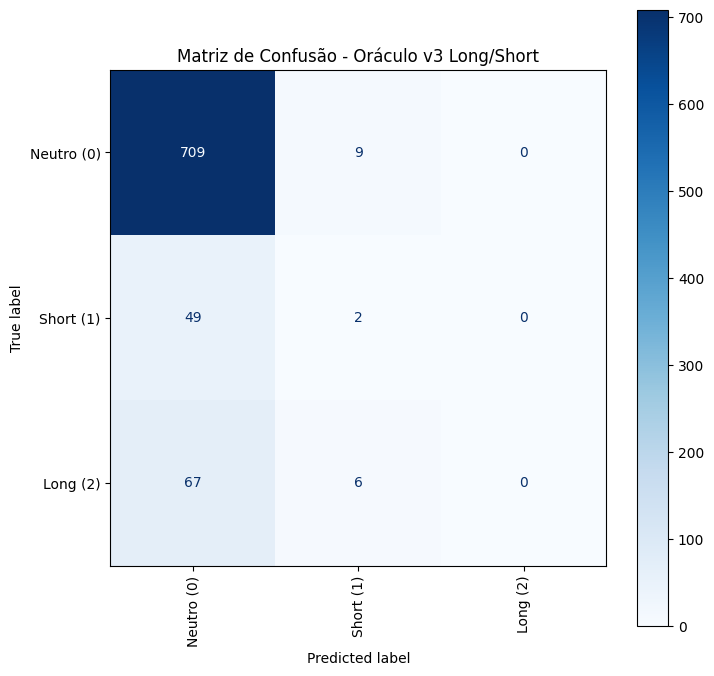

In [9]:
# --- CÉLULA 3 (v3): AVALIAÇÃO DO MODELO LONG/SHORT ---

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf

# --------------------------------------------------------------------------
# PASSO 1: CARREGAR O MELHOR MODELO SALVO
# --------------------------------------------------------------------------
print("--- 1. Carregando o melhor modelo treinado ---")
# Carrega o modelo que foi salvo pelo ModelCheckpoint
best_model_v3 = tf.keras.models.load_model('oraculo_v3_long_short_model.h5')


# --------------------------------------------------------------------------
# PASSO 2: FAZER PREVISÕES NO CONJUNTO DE TESTE
# --------------------------------------------------------------------------
print("\n--- 2. Fazendo previsões no conjunto de teste ---")
# O modelo retorna as probabilidades para cada uma das 3 classes
y_pred_proba = best_model_v3.predict(X_test_seq)

# Para obter a classe prevista, pegamos o índice da maior probabilidade
y_pred = np.argmax(y_pred_proba, axis=1)


# --------------------------------------------------------------------------
# PASSO 3: ANALISAR OS RESULTADOS
# --------------------------------------------------------------------------
print("\n--- 3. Relatório de Classificação ---")
# Lembre-se que y_test_seq contém os rótulos verdadeiros
# Nomes das classes para o relatório
target_names = ['Neutro (0)', 'Short (1)', 'Long (2)']

# Imprime o relatório de precisão, recall e f1-score
print(classification_report(y_test_seq, y_pred, target_names=target_names))


print("\n--- 4. Matriz de Confusão ---")
# A Matriz de Confusão mostra visualmente os acertos e erros
cm = confusion_matrix(y_test_seq, y_pred)

# Plota a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.title('Matriz de Confusão - Oráculo v3 Long/Short')
plt.show()


--- Reavaliando as previsões com um limiar de confiança ---

--- NOVO Relatório de Classificação (com Limiar) ---
              precision    recall  f1-score   support

  Neutro (0)       0.87      0.82      0.85       718
   Short (1)       0.08      0.12      0.10        51
    Long (2)       0.11      0.14      0.12        73

    accuracy                           0.72       842
   macro avg       0.35      0.36      0.35       842
weighted avg       0.76      0.72      0.74       842


--- NOVA Matriz de Confusão (com Limiar) ---


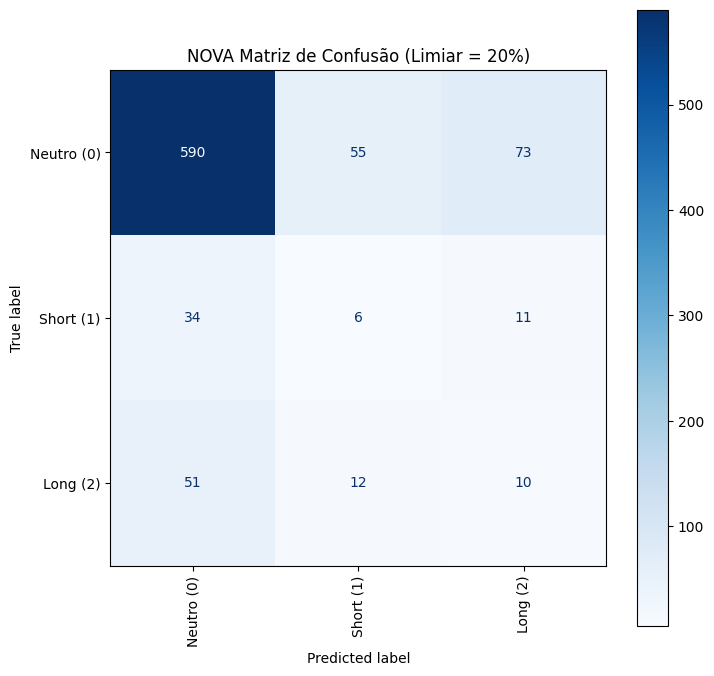

In [10]:
# --- CÉLULA 4 (v3): AVALIAÇÃO COM LIMIAR DE CONFIANÇA ---

print("--- Reavaliando as previsões com um limiar de confiança ---")

# --- Parâmetros ---
# Vamos definir um limiar de 20%. Se a prob. de Long ou Short for maior que isto, agimos.
CONFIDENCE_THRESHOLD = 0.20

# --- Novas Regras de Decisão ---
# Inicializa as novas previsões como 0 (Neutro)
new_preds = np.zeros_like(y_test_seq)

# Probabilidades para a classe Short (coluna 1)
prob_short = y_pred_proba[:, 1]
# Probabilidades para a classe Long (coluna 2)
prob_long = y_pred_proba[:, 2]

# Aplica as novas regras
new_preds[prob_short > CONFIDENCE_THRESHOLD] = 1  # Prever Short
new_preds[prob_long > CONFIDENCE_THRESHOLD] = 2   # Prever Long

# --- Análise dos Novos Resultados ---
print("\n--- NOVO Relatório de Classificação (com Limiar) ---")
print(classification_report(y_test_seq, new_preds, target_names=target_names, zero_division=0))

print("\n--- NOVA Matriz de Confusão (com Limiar) ---")
new_cm = confusion_matrix(y_test_seq, new_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=new_cm, display_labels=target_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.title('NOVA Matriz de Confusão (Limiar = 20%)')
plt.show()


--- Otimizando o limiar para aumentar a precisão ---

--- RELATÓRIO DE CLASSIFICAÇÃO (Limiar = 35.0%) ---
              precision    recall  f1-score   support

  Neutro (0)       0.86      0.98      0.92       718
   Short (1)       0.09      0.04      0.05        51
    Long (2)       0.00      0.00      0.00        73

    accuracy                           0.84       842
   macro avg       0.32      0.34      0.32       842
weighted avg       0.74      0.84      0.79       842


--- MATRIZ DE CONFUSÃO (Limiar = 35.0%) ---


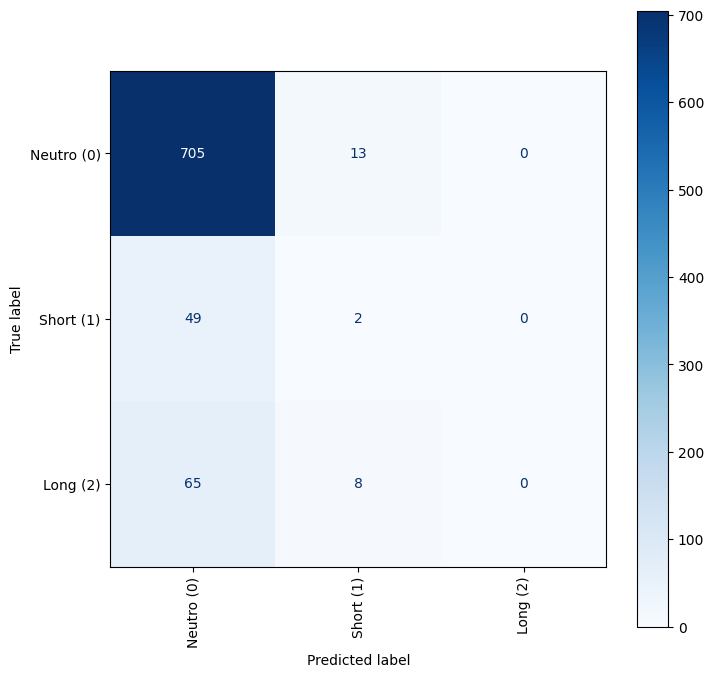

In [11]:
# --- CÉLULA 5 (v3): OTIMIZAÇÃO DO LIMIAR DE CONFIANÇA ---

print("--- Otimizando o limiar para aumentar a precisão ---")

# --- Parâmetros ---
# Vamos ser mais exigentes. Aumentamos o limiar para 35%.
CONFIDENCE_THRESHOLD_OTIMIZADO = 0.35

# --- Novas Regras de Decisão ---
new_preds_optimized = np.zeros_like(y_test_seq)
prob_short = y_pred_proba[:, 1]
prob_long = y_pred_proba[:, 2]

new_preds_optimized[prob_short > CONFIDENCE_THRESHOLD_OTIMIZADO] = 1
new_preds_optimized[prob_long > CONFIDENCE_THRESHOLD_OTIMIZADO] = 2

# --- Análise dos Novos Resultados ---
print(f"\n--- RELATÓRIO DE CLASSIFICAÇÃO (Limiar = {CONFIDENCE_THRESHOLD_OTIMIZADO*100}%) ---")
print(classification_report(y_test_seq, new_preds_optimized, target_names=target_names, zero_division=0))

print(f"\n--- MATRIZ DE CONFUSÃO (Limiar = {CONFIDENCE_THRESHOLD_OTIMIZADO*100}%) ---")
cm_optimized = confusion_matrix(y_test_seq, new_preds_optimized)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_optimized, display_labels=target_names)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.show()


--- Iniciando Backtest Financeiro da Estratégia Especialista em Shorts ---

--- RESULTADOS DO BACKTEST (Short-Only) ---
Total de Trades Executados: 23
Taxa de Acerto (Win Rate): 8.70%
Lucro/Prejuízo Total: $-24.03

Motivos de Saída:
exit_reason
Stop-Loss    23
Name: count, dtype: int64


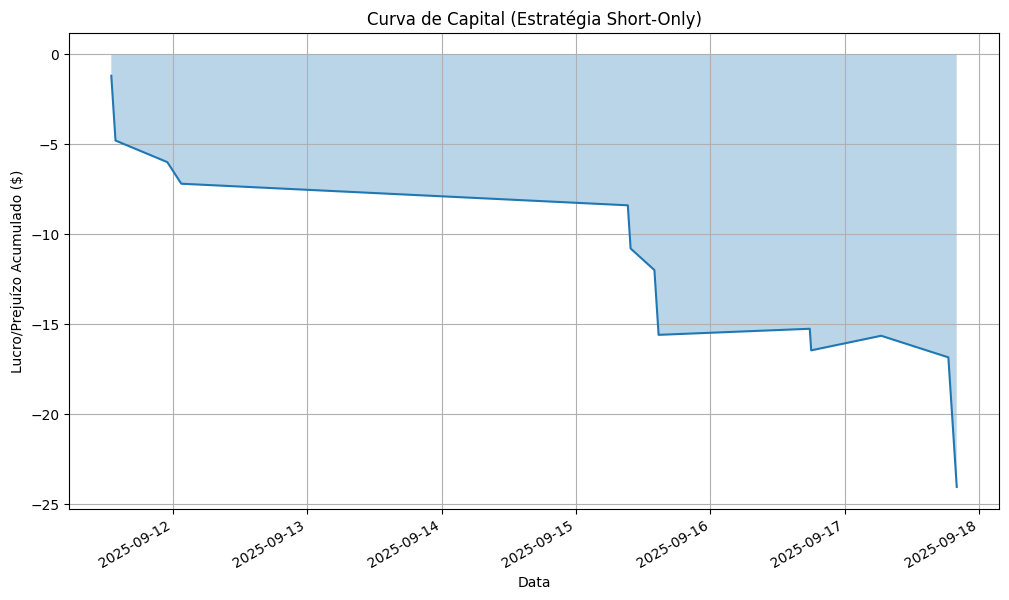

In [12]:
# --- CÉLULA 6 (v3): BACKTEST FINANCEIRO DA ESTRATÉGIA "SHORT-ONLY" ---

import matplotlib.pyplot as plt

print("--- Iniciando Backtest Financeiro da Estratégia Especialista em Shorts ---")

# --- Parâmetros da Simulação ---
investment_per_trade = 100
threshold = 0.35  # Nosso limiar otimizado
commission_rate = 0.001

# --- Parâmetros de Gestão de Risco (para Shorts) ---
stop_loss_pct = 0.01
breakeven_trigger_pct = 0.015 # Se o preço CAIR 1.5%, ativamos o breakeven
trailing_stop_pct = 0.01 # O Trailing Stop ficará 1% ACIMA do preço mais baixo atingido

# --- Preparar Dados para a Simulação ---
# Usamos as previsões de probabilidade do teste
sim_df = df_final.loc[X_test.index].iloc[len(X_test) - len(y_pred_proba):].copy()
sim_df['prob_short'] = y_pred_proba[:, 1] # Probabilidades apenas da classe Short

trades = []

# Itera sobre o dataframe de teste
for i in range(len(sim_df) - 1):
    
    # CONDIÇÃO DE ENTRADA: Apenas para Shorts
    if sim_df['prob_short'].iloc[i] > threshold:
        
        entry_price = sim_df['open'].iloc[i+1]
        entry_time = sim_df.index[i+1]
        
        stop_loss_price = entry_price * (1 + stop_loss_pct) # SL fica ACIMA do preço de entrada
        breakeven_price = entry_price * (1 - breakeven_trigger_pct) # BE é ativado se o preço CAIR
        
        breakeven_activated = False
        trailing_stop_activated = False
        lowest_price_since_entry = entry_price
        
        exit_reason = "Fim do Backtest"
        
        for j in range(i + 1, len(sim_df)):
            current_low = sim_df['low'].iloc[j]
            current_high = sim_df['high'].iloc[j]
            
            if current_high >= stop_loss_price: # Se o preço SOBE e atinge o SL
                exit_price = stop_loss_price
                exit_reason = "Stop-Loss"
                break
            
            lowest_price_since_entry = min(lowest_price_since_entry, current_low)
            
            if not breakeven_activated and lowest_price_since_entry <= breakeven_price:
                breakeven_activated = True
                trailing_stop_activated = True
                stop_loss_price = entry_price
            
            if trailing_stop_activated:
                new_trailing_stop = lowest_price_since_entry * (1 + trailing_stop_pct) # TS segue o preço para baixo
                if new_trailing_stop < stop_loss_price:
                    stop_loss_price = new_trailing_stop
        else:
            exit_price = sim_df['close'].iloc[-1]

        # Cálculo do P&L para uma operação SHORT
        pnl_percent = (entry_price - exit_price) / entry_price
        pnl_value = investment_per_trade * pnl_percent
        commission = (investment_per_trade * commission_rate) + (abs(pnl_value + investment_per_trade) * commission_rate)
        
        trades.append({
            'entry_time': entry_time,
            'pnl_$': pnl_value - commission,
            'exit_reason': exit_reason
        })
        
        i = j
        if i >= len(sim_df) - 1: break

# --- Análise dos Resultados ---
if not trades:
    print("\nNenhum trade de Short foi executado na simulação.")
else:
    results_df_v3 = pd.DataFrame(trades)
    
    total_trades = len(results_df_v3)
    winning_trades = (results_df_v3['pnl_$'] > 0).sum()
    win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0
    total_pnl = results_df_v3['pnl_$'].sum()
    
    print("\n--- RESULTADOS DO BACKTEST (Short-Only) ---")
    print(f"Total de Trades Executados: {total_trades}")
    print(f"Taxa de Acerto (Win Rate): {win_rate:.2f}%")
    print(f"Lucro/Prejuízo Total: ${total_pnl:.2f}")
    
    print("\nMotivos de Saída:")
    print(results_df_v3['exit_reason'].value_counts())
    
    results_df_v3['cumulative_pnl'] = results_df_v3['pnl_$'].cumsum()
    results_df_v3.set_index('entry_time', inplace=True)
    
    plt.figure(figsize=(12, 7))
    results_df_v3['cumulative_pnl'].plot(kind='line', title='Curva de Capital (Estratégia Short-Only)')
    plt.fill_between(results_df_v3.index, results_df_v3['cumulative_pnl'], 0, alpha=0.3)
    plt.ylabel('Lucro/Prejuízo Acumulado ($)')
    plt.xlabel('Data')
    plt.grid(True)
    plt.show()
